In [27]:
import math
import os
import random

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructField, StructType

import settings as settings
from logic.hasher import Hasher
from logic.loader import LoaderStrategy
from logic.utils import timeit
from logic.vectorizator import Vectorizator

# Если hadoop_home уже настроен это трока не нужна
os.environ['HADOOP_HOME'] = r"D:\Programms\Spark\spark-2.4.4-bin-hadoop2.7"


def distance(one, other):
    summa = 0.0
    for d in range(len(one)):
        delta = one[d] - other[d]
        summa += delta * delta
    return math.sqrt(summa)


def load_hasher_vectorizer(loader, spark):
    spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 100 * 1024 * 1024)

    tech_path = settings.TECH_PATH
    filepath = loader.join(tech_path, 'hash')

    hasher = Hasher(spark, loader, filepath, bucket_length=0.0001,
                    num_hash_tables=1)
    hasher.load()
    vectorizator = Vectorizator(spark, loader, tech_path, sparse=False)
    vectorizator.load()
    return hasher, vectorizator


def vectors_generating(loader):
    input_path = settings.INPUT_DATA_PATH
    filename = loader.get_path(input_path, "availiableValues.txt")

    fr = open(filename, "r")

    vals = fr.read().splitlines()
    vec1 = ["1", "3359", "-12862"]
    vec2 = ["1", "3359", "-12862"]

    for v in vals:
        t = v.split('|')
        firstVal = t[random.randint(0, len(t) - 1)]
        while firstVal is None or firstVal == "":
            firstVal = t[random.randint(0, len(t) - 1)]

        secondVal = t[random.randint(0, len(t) - 1)]
        while secondVal is None or secondVal == "" or secondVal == firstVal:
            secondVal = t[random.randint(0, len(t) - 1)]
        vec1.append(firstVal)
        vec2.append(secondVal)

    return vec1, vec2


def save_vectors(vec1, vec2):
    fn1 = "rand_vector1.txt"
    fn2 = "rand_vector2.txt"

    fw1 = open(fn1, "w")
    fw2 = open(fn2, "w")

    v1 = '|'.join(map(str, vec1))
    v2 = '|'.join(map(str, vec2))
    print(v1 + '\n' + v2)
    fw1.write(v1)
    fw2.write(v2)
    return fn1, fn2


def nullcheck(spark, vectorizator, fn1, fn2, schema):
    """
    Vectorize and hash segment, run LSH to find ANN, check stats(if needed).
    """
    # segment preparation
    with timeit('Read segment from file: {time:.2f} s.'):
        df = spark.read.csv(fn1, header='false', schema=schema, sep="|")

    print('Loaded vectorization model')
    selected_columns = ['PERSON_ID', 'FEATURES']
    df = vectorizator.transform(df, selected_columns, '2_df_vectorized_not_sparse.parquet')

    with timeit('Read segment from file: {time:.2f} s.'):
        df_seg = spark.read.csv(fn2, header='false', schema=schema, sep="|")

    n_segment = df_seg.count()
    print(f'n segment: {n_segment}.')

    df_seg = vectorizator.transform(df_seg, selected_columns, '2_segment_vectorized_not_sparse.parquet')

    nz_pairs_distance = df.crossJoin(df_seg).withColumn("ABS_DISTANCE", squared_udf(df.FEATURES, df_seg.FEATURES))

    nz_pairs_distance.show(20)

    avail = nz_pairs_distance.take(nz_pairs_distance.count())
    res = avail[0].asDict()["ABS_DISTANCE"]
    return res


def nullmaking_list(loader, spark, vectorizator, vec1, vec2):
    input_path = settings.INPUT_DATA_PATH
    filename = loader.get_path(input_path, "seg_col_names.txt")
    columns_seg = open(filename).read().splitlines()
    columns = [StructField(column, StringType(), True) for column in columns_seg]
    schema = StructType(columns)

    res = ""
    res += str(nullcheck_list(spark, vectorizator, vec1, vec2, schema)) + '\n'
    for i in range(3, len(vec1)):
        v1 = vec1.copy()
        v2 = vec2.copy()
        v1[i] = None
        v2[i] = None
        print(v1)
        res += str(nullcheck_list(spark, vectorizator, v1, v2, schema)) + '\n'
    return res[:-1]


def nullcheck_list(spark, vectorizator, vec1, vec2, schema):
    """
    Vectorize and hash segment, run LSH to find ANN, check stats(if needed).
    """
    spark.udf.register("dist", distance)
    squared_udf = udf(distance)

    with timeit('Read segment from file: {time:.2f} s.'):
        df = spark.createDataFrame(
            [
                vec1,
            ],
            schema=schema
        )

    selected_columns = ['PERSON_ID', 'FEATURES']
    df = vectorizator.transform(df, selected_columns, '2_df_vectorized_not_sparse.parquet')

    with timeit('Read segment from file: {time:.2f} s.'):
        df_seg = spark.createDataFrame(
            [
                vec2,
            ],
            schema=schema
        )

    n_segment = df_seg.count()
    print(f'n segment: {n_segment}.')

    df_seg = vectorizator.transform(df_seg, selected_columns, '2_segment_vectorized_not_sparse.parquet')

    nz_pairs_distance = df.crossJoin(df_seg).withColumn("ABS_DISTANCE", squared_udf(df.FEATURES, df_seg.FEATURES))

    nz_pairs_distance.show(20)

    avail = nz_pairs_distance.take(nz_pairs_distance.count())
    res = avail[0].asDict()["ABS_DISTANCE"]
    return res

def Nmaxelements(list1, n):
    list1 = list(map(float, list1))
    final_list = np.array(list1).argsort()[-n:]
#     print(final_list)
    return final_list


def Nminelements(list1, n): 
    list1 = list(map(float, list1))
    final_list = np.array(list1).argsort()[:n]
    return final_list


def min_max_nullmaking_list(loader, spark, vectorizator, vec1,vec2, list_to_null):
        # segment preparation
    vec1 = vec1.copy()
    vec2 = vec2.copy()
    filename = loader.get_path(input_path, "seg_col_names.txt")
    columns_seg = open(filename).read().splitlines()
    columns = [StructField(column, StringType(), True) for column in columns_seg]
    schema = StructType(columns)
    
    res = ""
    for i in list_to_null:
        vec1[i+3] = None
        vec2[i+3] = None
    res += str(nullcheck_list(spark, vectorizator, vec1, vec2, schema)) + '\n'
    return res

In [31]:
def get_spark_memory(cpus: int):
    mapping = {
        4: 11,
        16: 56,
        64: 244
    }
    return f'{mapping.get(cpus, 3)}g'


def get_spark_session(loader_type: str, cpus: int) -> SparkSession:
    """Create SparkSession with different config for different parameters."""
    spark = SparkSession.builder.master(f"local[{cpus}]")
    if loader_type == 's3':
        spark = spark.config('spark.jars.packages',
                             'org.apache.hadoop:hadoop-aws:2.7.6')
    spark = spark \
        .config('spark.driver.memory', get_spark_memory(cpus))
    return spark.getOrCreate()


if __name__ == '__main__':
    with timeit('Total time for `main.py`: {time:.2f} s.'):
        # initialize Spark
        spark = get_spark_session(settings.LOADER, settings.CPU_COUNT)
        sc: SparkContext = spark.sparkContext
        print(f'spark.driver.memory: {sc.getConf().get("spark.driver.memory")}')
        print(f'spark.master: {sc.getConf().get("spark.master")}')

        # initialize loader
        root_path = settings.ROOT_PATH
        loader = LoaderStrategy.get_loader(settings.LOADER)(
            sc=sc, root_path=root_path)
        print(f'Root path in loader: {loader.root_path}')

        # select action
        action = settings.ALGORITHM_ID
        print(f'Action: {action}')
#         h, v = load_hasher_vectorizer(loader, spark)
#         vec1, vec2 = vectors_generating(loader)
#         fn1, fn2 = save_vectors(vec1, vec2)
        input_path = settings.INPUT_DATA_PATH

#         res = ""
#         if action == 1:
#             res = nullmaking_list(loader, spark, v, vec1, vec2)
#         else:
#             raise ValueError(f'Action {action} is not recognized.')
#         fw = open("nulls_stats.txt", "w")
#         fw.write(res)
#         fw.close()
        fr = open("nulls_stats.txt", "r")
        res = fr.read()   
        res_list = res.splitlines()[1:]
        
        vec1 = open("rand_vector1.txt", "r").read().split('|')
        vec2 = open("rand_vector2.txt", "r").read().split('|')

        fw1 = open("maxes.txt", "w")
        fw2 = open("mins.txt", "w")

        for i in range(2, len(res_list)+1):
            max_list = Nmaxelements(res_list, i)
            min_list = Nminelements(res_list, i)
            max_res = min_max_nullmaking_list(loader, spark, v, vec1,vec2, max_list)
            print(max_res)
            min_res = min_max_nullmaking_list(loader, spark, v, vec1,vec2, min_list) 
            print(min_res)

            fw1.write(max_res)
            fw2.write(min_res)

        fw2.close()
        fw1.close()


------------------------------ 
Current Time:  14:35:22
spark.driver.memory: 3g
spark.master: local[6]
Root path in loader: 
Action: 1
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 

18.083141320025124

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', None, '8 Persons', '200000', '160000', 'Unknow

13.490737563232042

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', None, '64', None, None, '8 Persons', '200000', '160000', 'Unknown', 'Ret

10.816653826391969

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', None, None, 'New', None, '64', None, None, '8 Persons', '200000', '160000', 'Unknown', 'Retail 

9.591663046625438

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', None, None, None, None, 'New', None, '64', None, None, '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', '

9.16515138991168

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', None, None, None, None, None, None, 'New', None, '64', None, None, '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', None, 'Likely', 'Co

------------------------------ 
Current Time:  14:41:57
Write transformed df to file: 4.19 s.
------------------------------ 
Current Time:  14:42:01
Read segment from file: 0.04 s.
n segment: 1.
------------------------------ 
Current Time:  14:42:05
Write transformed df to file: 3.91 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[2.0,0.0,0.0,0.0,...|   -12862|[0.0,2.0,1.0,1.0,...|26.514147167125703|
+---------+--------------------+---------+--------------------+------------------+

26.514147167125703

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

n segment: 1.
------------------------------ 
Current Time:  14:43:10
Write transformed df to file: 3.96 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[2.0,0.0,0.0,0.0,...|   -12862|[0.0,2.0,1.0,1.0,...|26.476404589747453|
+---------+--------------------+---------+--------------------+------------------+

26.476404589747453

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Lo

26.43860813280457

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', None, None, 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', None, 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', None, 'Medium', None, 'Medium', 'Low', None, None, None, None, None, 'No', 'Unknown', 'L

------------------------------ 
Current Time:  14:45:28
Write transformed df to file: 3.96 s.
------------------------------ 
Current Time:  14:45:32
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  14:45:36
Write transformed df to file: 4.26 s.
+---------+--------------------+---------+--------------------+-----------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|     ABS_DISTANCE|
+---------+--------------------+---------+--------------------+-----------------+
|   -12862|[3.0,4.0,0.0,0.0,...|   -12862|[3.0,4.0,1.0,1.0,...|6.928203230275509|
+---------+--------------------+---------+--------------------+-----------------+

6.928203230275509

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 

Write transformed df to file: 3.92 s.
+---------+--------------------+---------+--------------------+-----------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|     ABS_DISTANCE|
+---------+--------------------+---------+--------------------+-----------------+
|   -12862|[3.0,4.0,0.0,0.0,...|   -12862|[3.0,4.0,1.0,1.0,...|6.324555320336759|
+---------+--------------------+---------+--------------------+-----------------+

6.324555320336759

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', '

5.916079783099616

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', None, None, None, None, None, None, None, 'Low', None, None, '80000', None, None, None, None, None, None, 'New', None, '64', None, None, '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', None, 'Unknown', None, 'Likely', 'Conventional', None, None, None, 'Unknown Not scored', 

------------------------------ 
Current Time:  14:48:58
Write transformed df to file: 4.04 s.
------------------------------ 
Current Time:  14:49:02
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  14:49:06
Write transformed df to file: 4.19 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[2.0,0.0,2.0,2.0,...|   -12862|[0.0,2.0,2.0,2.0,...|26.267851073127396|
+---------+--------------------+---------+--------------------+------------------+

26.267851073127396

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

Write transformed df to file: 4.37 s.
+---------+--------------------+---------+--------------------+---------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|   ABS_DISTANCE|
+---------+--------------------+---------+--------------------+---------------+
|   -12862|[2.0,0.0,2.0,2.0,...|   -12862|[0.0,2.0,2.0,2.0,...|26.229754097208|
+---------+--------------------+---------+--------------------+---------------+

26.229754097208

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Un

26.19160170741759

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', None, None, 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', None, 'Less than HS Diploma - Ex Like', 'FHA ', None, 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', None, 'Medium', None, 'Medium', 'Low', None, None, None, None, None, 'No', None, 'Likely'

------------------------------ 
Current Time:  14:52:35
Write transformed df to file: 3.95 s.
------------------------------ 
Current Time:  14:52:39
Read segment from file: 0.03 s.
n segment: 1.
------------------------------ 
Current Time:  14:52:44
Write transformed df to file: 4.10 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[3.0,4.0,0.0,0.0,...|   -12862|[3.0,4.0,1.0,1.0,...|5.0990195135927845|
+---------+--------------------+---------+--------------------+------------------+

5.0990195135927845

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

4.898979485566356

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', 'Low', '\\Null', None, None, None, None, None, None, None, 'Low', None, None, '80000', None, None, None, None, None, None, 'New', None, '64', None, None, '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', None, 'Unknown', None, 'Likely', 'Conventional', None, None, None, 'Unknown Not scored', 

------------------------------ 
Current Time:  14:55:04
Write transformed df to file: 4.19 s.
------------------------------ 
Current Time:  14:55:09
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  14:55:13
Write transformed df to file: 4.38 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[2.0,0.0,2.0,2.0,...|   -12862|[0.0,2.0,2.0,2.0,...|25.942243542145693|
+---------+--------------------+---------+--------------------+------------------+

25.942243542145693

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

25.787593916455254

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', None, None, None, None, 'Yes', 'Unknown', 'High', 'Male', 'Medium', None, 'Less than HS Diploma - Ex Like', 'FHA ', None, 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', None, 'Medium', None, 'Medium', 'Low', None, None, None, None, None, None, None, 'Likely', None, N

------------------------------ 
Current Time:  14:57:35
Write transformed df to file: 3.92 s.
------------------------------ 
Current Time:  14:57:39
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  14:57:43
Write transformed df to file: 4.03 s.
+---------+--------------------+---------+--------------------+-----------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|     ABS_DISTANCE|
+---------+--------------------+---------+--------------------+-----------------+
|   -12862|[3.0,4.0,2.0,2.0,...|   -12862|[3.0,4.0,2.0,2.0,...|4.123105625617661|
+---------+--------------------+---------+--------------------+-----------------+

4.123105625617661

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 

3.872983346207417

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', None, '\\Null', None, None, None, None, None, None, None, None, None, None, '80000', None, None, None, None, None, None, 'New', None, '64', None, None, '8 Persons', '200000', '160000', None, 'Retail Sales', None, None, None, None, None, None, None, None, 'Unknown Not scored', None, None, 'West Virginia

------------------------------ 
Current Time:  14:59:59
Write transformed df to file: 4.59 s.
------------------------------ 
Current Time:  15:00:04
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  15:00:08
Write transformed df to file: 4.20 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[3.0,0.0,2.0,2.0,...|   -12862|[3.0,2.0,2.0,2.0,...|25.238858928247925|
+---------+--------------------+---------+--------------------+------------------+

25.238858928247925

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

25.079872407968907

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'High', 'Unlikely', 'High', 'High', None, 'Medium', None, 'Medium', 'Low', None, None, None, None, None, None, None, 'Likely', None, None, None, 'Low', None, None, None, None, None, None, None, None, None, None, 

------------------------------ 
Current Time:  15:02:28
Write transformed df to file: 4.16 s.
------------------------------ 
Current Time:  15:02:32
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  15:02:37
Write transformed df to file: 4.73 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[3.0,4.0,2.0,2.0,...|   -12862|[3.0,4.0,2.0,2.0,...|2.8284271247461903|
+---------+--------------------+---------+--------------------+------------------+

2.8284271247461903

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

------------------------------ 
Current Time:  15:03:55
Write transformed df to file: 4.26 s.
------------------------------ 
Current Time:  15:03:59
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  15:04:03
Write transformed df to file: 4.16 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[3.0,4.0,2.0,2.0,...|   -12862|[3.0,4.0,2.0,2.0,...|23.130067012440755|
+---------+--------------------+---------+--------------------+------------------+

23.130067012440755

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

------------------------------ 
Current Time:  15:05:15
Write transformed df to file: 4.25 s.
------------------------------ 
Current Time:  15:05:20
Read segment from file: 0.02 s.
n segment: 1.
------------------------------ 
Current Time:  15:05:24
Write transformed df to file: 4.20 s.
+---------+--------------------+---------+--------------------+------------------+
|PERSON_ID|            FEATURES|PERSON_ID|            FEATURES|      ABS_DISTANCE|
+---------+--------------------+---------+--------------------+------------------+
|   -12862|[3.0,4.0,2.0,2.0,...|   -12862|[3.0,4.0,2.0,2.0,...|1.7320508075688772|
+---------+--------------------+---------+--------------------+------------------+

1.7320508075688772

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Med

In [40]:
max_list = Nmaxelements(res_list, 59)
min_list = Nminelements(res_list, 59)
max_res = min_max_nullmaking_list(loader, spark, v, vec1,vec2, max_list)
print(max_res)
min_res = min_max_nullmaking_list(loader, spark, v, vec1,vec2, min_list) 
print(min_res)

['1', '3359', '-12862', 'Low', '\\Null', 'Unknown', 'unknown', 'Yes', 'Unknown', 'High', 'Male', 'Medium', 'Low', 'Less than HS Diploma - Ex Like', 'FHA ', '80000', 'Variable', 'Modeled likely to have a child', 'High', 'Unlikely', 'High', 'High', 'New', 'Medium', '64', 'Medium', 'Low', '8 Persons', '200000', '160000', 'Unknown', 'Retail Sales', 'No', 'Unknown', 'Likely', 'Likely', 'Conventional', 'Likely', 'Low', 'Low', 'Unknown Not scored', 'Low', 'Low', 'West Virginia', 'Yes', 'Likely', 'Fixed', 'Low', 'Low Income Elders', 'Medium', 'Unlikely', 'SFDU', 'Yes', 'No', 'No', 'Yes', 'Unknown', '120000', 'no', 'Unknown or not scored', 'Low', 'High']
['1', '3359', '-12862', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None

In [55]:
import os
from functools import reduce
from typing import List
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pyspark.sql.functions as f
from matplotlib.axes import Axes
from pyspark.sql import DataFrame
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col
from pyspark.sql.types import *
import re
def autolabel(ax, rects, is_float=True):
        """
        Attach a text label above each bar in *rects*, displaying its height.
        :param ax: Axes to draw info on
        :param rects: bars of plot to draw labels on
        :param is_float: if values on plot are float values(for normalized values for example)
        :return:
        """
        alls = []
        for rect in rects:
            height = rect.get_height()
            pattern = '{0:.2f}' if is_float else '{}'
            ax.annotate(pattern.format(height if is_float else int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

            
def show_plot_for_distance_in_each_null_column(ax: Axes, values: List):
    """
    function to represent
    :param ax: Axes to draw info on
    :param values: values to represent
    :return: None
    """
    bar_width = 1
    rec = []
    delta = 1
    v = [i for i in range(len(values))]
    values = [float(i) for i in values]
    rec.append(ax.bar(np.array(v)+bar_width-delta, np.array(values),  width=bar_width, edgecolor='white'))    
    ax.grid()
    
    for r in rec:
        autolabel(ax, r)
    ax.set_xticks(np.arange(len(values)))
    ax.set_xticklabels(range(0, len(values)))
    ax.set_xlabel("Distance for null column")
    ax.set_ylabel("Null column index(index 0 for no null at all)")
    
def show_plot_for_distance_in_several_null_column(ax: Axes, values: List):
    """
    function to represent
    :param ax: Axes to draw info on
    :param values: values to represent
    :return: None
    """
    bar_width = 1
    rec = []
    delta = 1
    v = [i for i in range(len(values))]
    values = [float(i) for i in values]
    rec.append(ax.bar(np.array(v)+bar_width-delta, np.array(values),  width=bar_width, edgecolor='white'))    
    ax.grid()
    
    for r in rec:
        autolabel(ax, r)
    ax.set_xticks(np.arange(len(values)+1))
    ax.set_xticklabels(range(2, len(values) + 2))
    ax.set_xlabel("Distance for null columns")
    ax.set_ylabel("Null column count")

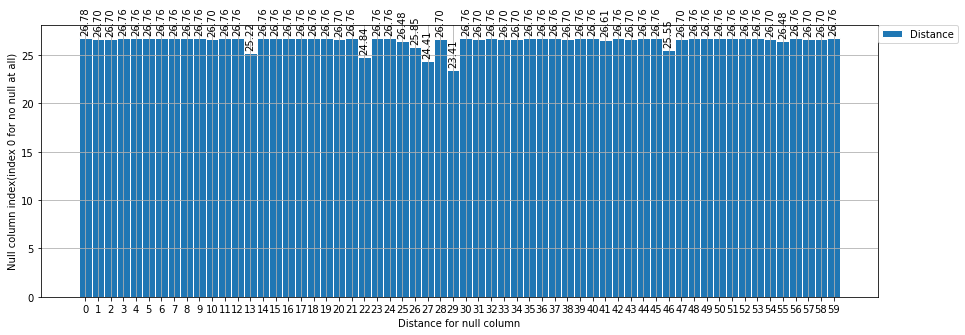

In [56]:
fig, ax1 = plt.subplots(figsize=(15,5))
res_list = open("nulls_stats.txt","r").read().splitlines()
show_plot_for_distance_in_each_null_column(ax1, res_list)
ax1.legend(["Distance"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

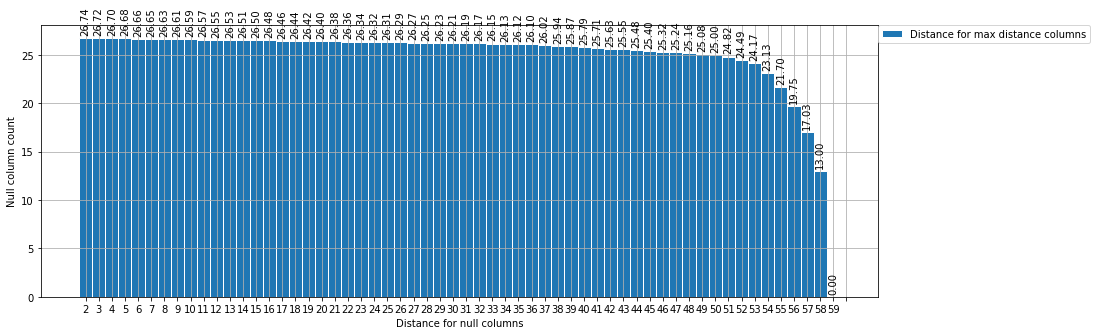

In [49]:
fig, ax2 = plt.subplots(figsize=(15,5))
max_list = open("maxes.txt","r").read().splitlines()
show_plot_for_distance_in_several_null_column(ax2, max_list)
ax2.legend(["Distance for max distance columns"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()

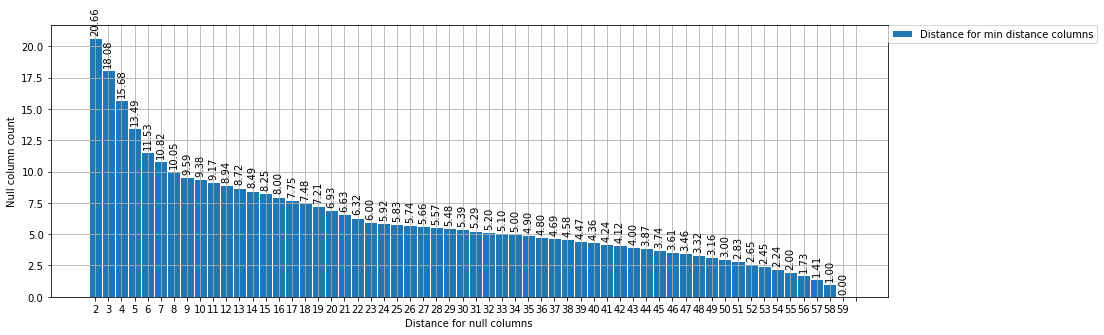

In [50]:
fig, ax3 = plt.subplots(figsize=(15,5))
min_list = open("mins.txt", "r").read().splitlines()
show_plot_for_distance_in_several_null_column(ax3, min_list)
ax3.legend(["Distance for min distance columns"], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.show()